####  This report examines the comparative effectiveness of two well-known time series forecasting models: ARIMA (Autoregressive Integrated Moving Average) and LSTM (Long Short-Term Memory), for predicting sales and share data.


In [ ]:
# Importing the libraries

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import itertools
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, History
import math
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import numpy as np
import tensorflow as tf

 First, I will analyze the Johnson and Johnson sales data using the ARIMA model, followed by the deep learning LSTM model.
Afterward, I will analyze the Amazon shares data using the same approach.


#### Arima Model For Johnson and Johnson Sales

In [ ]:
# Reading the data and setting the date as the index
data = pd.read_csv('jj.csv', index_col='date', parse_dates=True)
data.tail()


,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


Text(0.5, 1.0, 'Johnson & Johnson Sales Figure')

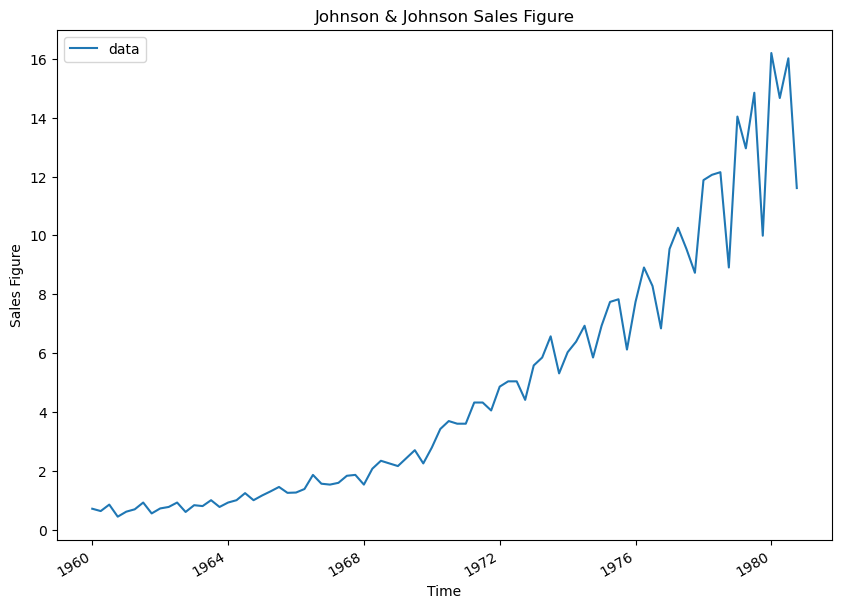

In [ ]:
# Checking the plot
data.plot()
plt.xlabel('Time')  # Labeling the x-axis as Time
plt.ylabel('Sales Figure')  # Labeling the y-axis as Sales Figure
plt.title('Johnson & Johnson Sales Figure')  # Setting the title for the plot


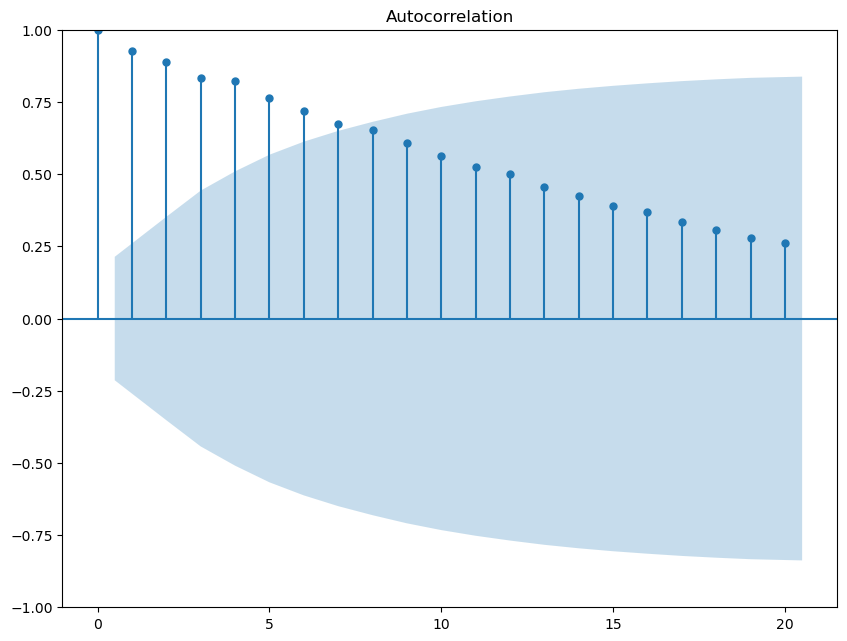

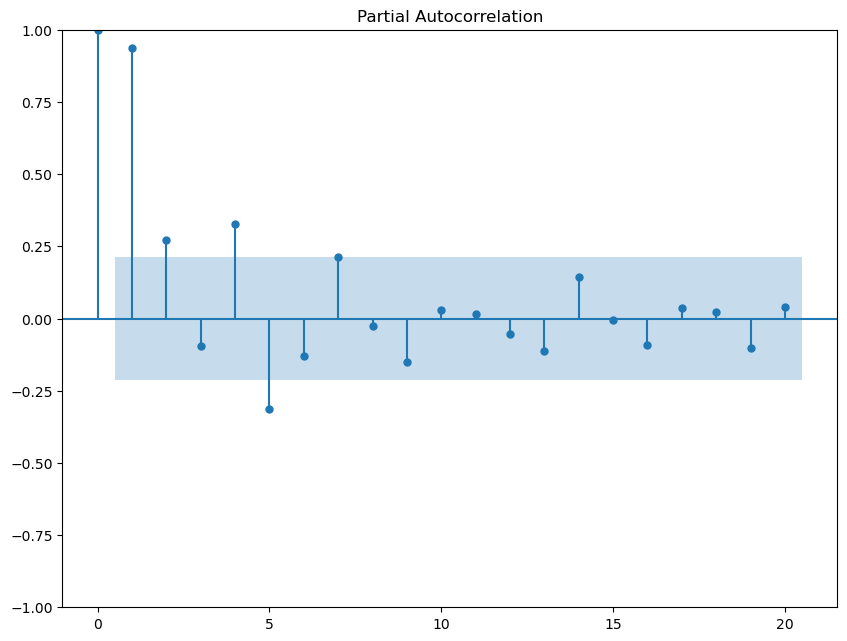

In [ ]:
# Checking the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
acf_plot = plot_acf(data['data'])
pacf_plot = plot_pacf(data['data'])


In [ ]:
# Checking if the model is stationary using the Augmented Dickey-Fuller (ADF) test
adf = adfuller(data['data'])
print(f'p-value: {adf[1]}')  # If the p-value is greater than 0.05, it suggests the data is not stationary


p-value: 1.0


In [ ]:
# Making the data stationary by taking the log and differencing

# taking the log to stabilize the variance
data_log = np.log(data['data'])
data_log

date
1960-01-01   -0.342490
1960-04-01   -0.462035
1960-07-02   -0.162519
1960-10-01   -0.820981
1961-01-01   -0.494296
                ...   
1979-10-01    2.301585
1980-01-01    2.785011
1980-04-01    2.685805
1980-07-02    2.773838
1980-10-01    2.451867
Name: data, Length: 84, dtype: float64

In [ ]:
# using differencing to remove trend
data_log_diff =data_log.diff().dropna()
data_log_diff.head()

date
1960-04-01   -0.119545
1960-07-02    0.299517
1960-10-01   -0.658462
1961-01-01    0.326684
1961-04-02    0.123233
Name: data, dtype: float64

Text(0.5, 1.0, 'Johnson & Johnson Sales Figure')

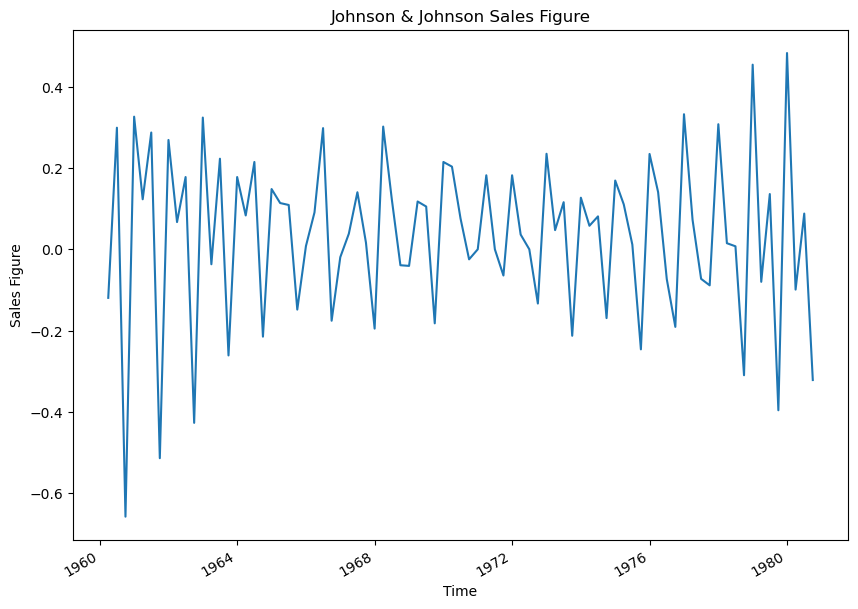

In [ ]:
# Checking the plot after applying logarithmic transformation and differencing
data_log_diff.plot()
plt.xlabel('Time')  # Labeling the x-axis as Time
plt.ylabel('Sales Figure')  # Labeling the y-axis as Sales Figure
plt.title('Johnson & Johnson Sales Figure')  # Setting the title for the plot

In [ ]:
# Confirming the stationarity with the adfuller test after making the data stationary
st=adfuller(data_log_diff)
print(f'p-value: {st[1]}')

p-value: 0.0004149731404440487


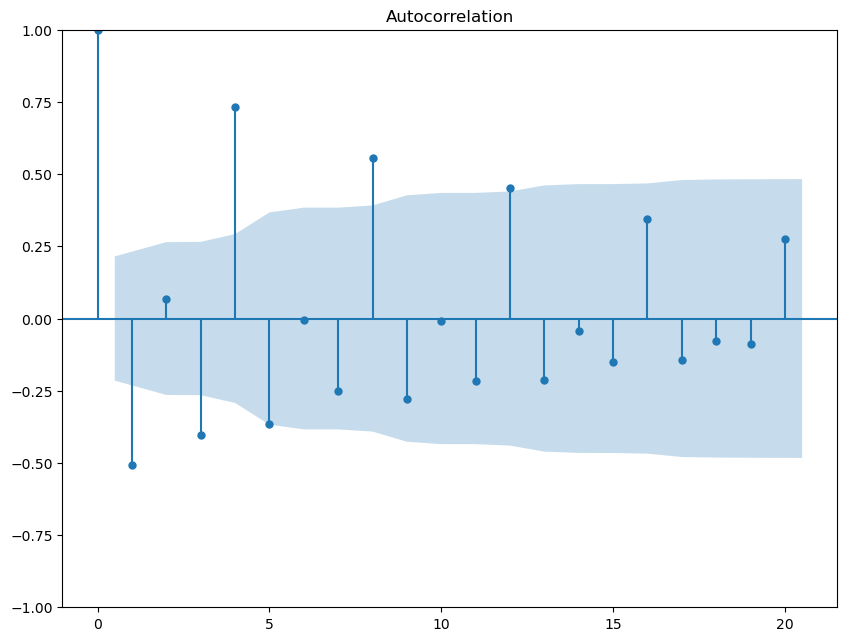

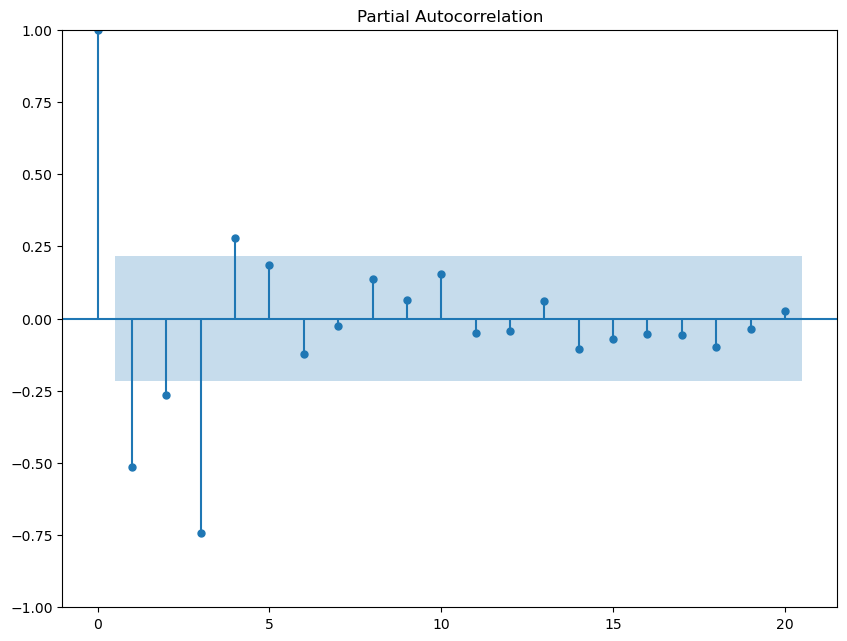

In [ ]:
# Checking the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) after making the data stationary
acf_data_plot = plot_acf(data_log_diff)
pacf_data_plot = plot_pacf(data_log_diff)


In [ ]:
# Finding the best ARMA(p,q) model fit using the pmdarima automated best model fit finder
auto_data = pm.auto_arima(data['data'], trace=True)
auto_data.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=240.020, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=297.285, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=264.953, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=255.333, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=295.995, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=238.454, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=229.503, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=259.465, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.412, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=228.486, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

B

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -108.243
Date:                Mon, 11 Mar 2024   AIC                            228.486
Time:                        20:34:11   BIC                            242.999
Sample:                             0   HQIC                           234.316
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3428      0.102      3.353      0.001       0.142       0.543
ar.L1         -0.9877      0.093    -10.622      0.000      -1.170      -0.805
ma.L1         -0.4190      0.163     -2.568      0.010      -0.739      -0.099
ma.L2         -0.5018      0.218     -2.305      0.021      -0.928      -0.075
ma.L3          0.6751      0.152      4.441      0.000       0.377       0.973
sigma2         0.7633      0.119      6.417      0.000       0.530       0.996
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):                13.31
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              12.13   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Splitting the data into train and test sets

# Calculating the length of the dataset
len_data = len(data)

# Selecting the first 70 data points for training
train_data = data[:70]

# Selecting the remaining data points for testing
test_data = data[70:]


### Johnson & Johnson ARIMA Model Building, Prediction, and Evaluation


In [ ]:
# Building the SARIMA model on the training data
model = SARIMAX(train_data['data'],
                order=(1, 1, 3),
                seasonal_order=(0, 0, 0, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   70
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 -50.220
Date:                Mon, 11 Mar 2024   AIC                            110.441
Time:                        20:34:12   BIC                            121.312
Sample:                             0   HQIC                           114.730
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5209      0.159      3.279      0.001       0.210       0.832
ma.L1         -1.1914      0.146     -8.133      0.000      -1.478      -0.904
ma.L2          0.2268      0.185      1.226      0.220      -0.136       0.589
ma.L3          0.4050      0.099      4.087      0.000       0.211       0.599
sigma2         0.2611      0.038      6.903      0.000       0.187       0.335
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                 6.29
Prob(Q):                              0.37   Prob(JB):                         0.04
Heteroskedasticity (H):              20.50   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Making predictions with the trained model
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1
pred = model.predict(start=start_index, end=end_index, type='levels')
pred.index = data.index[start_index:end_index+1]
print(pred)


date
1977-07-02     9.136924
1977-10-01     9.335460
1978-01-01     9.870670
1978-04-02    10.149452
1978-07-02    10.294666
1978-10-01    10.370305
1979-01-01    10.409704
1979-04-02    10.430226
1979-07-02    10.440916
1979-10-01    10.446484
1980-01-01    10.449385
1980-04-01    10.450895
1980-07-02    10.451682
1980-10-01    10.452092
Name: predicted_mean, dtype: float64


### Evaluating the Arima Model

In [ ]:
# Evaluating the model using Root Mean Square Error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test_data['data']))
print(rmse)

# Evaluating the model using Mean Absolute Error
mbe = mean_absolute_error(pred, test_data['data'])
print(mbe)

3.1194773145839974
2.5689740618152372


### Forecasting Johnson & Johnson Sales for the next 24 period

In [ ]:
# Building the SARIMA model on the full dataset
final_model = SARIMAX(data['data'],
                      order=(1, 1, 3),
                      seasonal_order=(0, 0, 0, 4),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_model = final_model.fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -107.883
Date:                Mon, 11 Mar 2024   AIC                            225.766
Time:                        20:34:12   BIC                            237.613
Sample:                             0   HQIC                           230.512
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0751      0.021    -51.231      0.000      -1.116      -1.034
ma.L1         -0.3097   3044.243     -0.000      1.000   -5966.917    5966.297
ma.L2         -0.4132   3987.035     -0.000      1.000   -7814.858    7814.031
ma.L3          0.8965   2729.088      0.000      1.000   -5348.018    5349.811
sigma2         0.8409   2559.812      0.000      1.000   -5016.299    5017.980
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):                14.59
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              59.18   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Specifying the range of forecast
start = len(data)-1
end = start + 24 - 1

# Perform the forecast
pred_result = final_model.get_prediction(start=start, end=end, dynamic=False, typ='levels')

# Accessing the predicted mean
pred_final = pred_result.predicted_mean.rename(' 24 period Forecast')

# Generate the index for future dates and assign it to the forecast
index_future_dates = pd.date_range(start='1980-10-01', periods=24, freq='Q')
pred_final.index = index_future_dates

In [ ]:
# getting the final forecast
predictions_int = final_model.get_forecast(steps=24)

# Accessing the predicted mean
predicted_mean = predictions_int.predicted_mean

# To get the confidence intervals for the forecast
conf_int = predictions_int.conf_int()

# If you want to display both the predicted mean and the confidence intervals
#print("Predicted Mean:\n", predicted_mean)
#print("\nConfidence Intervals:\n", conf_int)

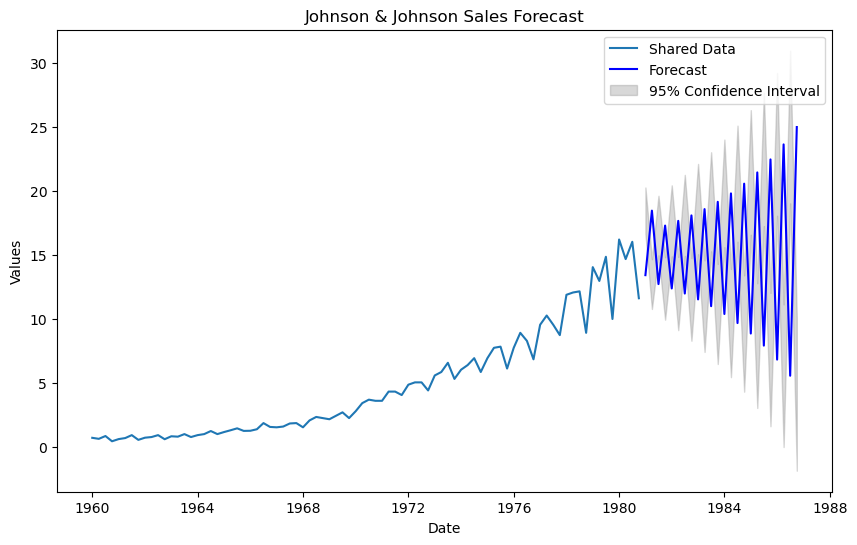

In [ ]:
# Plotting the data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['data'], label='Shared Data')  #
plt.plot(pred_final.index, pred_final, label='Forecast', color='blue')
plt.fill_between(pred_final.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

### LSTM Model for Johnson & Johnson Sales data

### Preprocessing the Data and Splitting the Data for the LSTM Model

In [ ]:
# Prepocessing the data so it can be suitable for Deep learning
scaler = MinMaxScaler()
scaled_data =scaler.fit_transform(data['data'].values.reshape(-1,1))

# splitting the data into training and testing
train_size = int(len(scaled_data) * 0.75) # size of training data is 90% of the total data
test_size = len(scaled_data) - train_size # size of testing data which will be 10%


train_data,test_data = scaled_data[0:train_size,:],scaled_data[train_size:len(scaled_data),:]
train_data.shape, test_data.shape


((63, 1), (21, 1))

### Specifying a 20 past period to use for prediction

In [ ]:
# number of previous time steps(sequence of time) to use before making prediction on the next one
steps=20

#creating a sequence of data that uses 20 past data(X) to make prediction(y)
train_generator_data= TimeseriesGenerator(train_data,train_data, length=steps, batch_size=5)
test_generator_data= TimeseriesGenerator(test_data, test_data, length=steps, batch_size=5)

### Building the LSTM model

In [ ]:
# Building a Sequential LSTM Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(20,1)))
model.add(LSTM(units=60, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(1))

# compiling the model
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the model on the training data and assessing  its performance on the validation data
model.fit(train_generator_data, epochs=100, batch_size=5)

Epoch 1/100
9/9 [==============================] - 8s 25ms/step - loss: 0.0364 - mean_absolute_error: 0.1281
Epoch 2/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0112 - mean_absolute_error: 0.0913
Epoch 3/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0044 - mean_absolute_error: 0.0579
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0031 - mean_absolute_error: 0.0495
Epoch 5/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0013 - mean_absolute_error: 0.0316
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0303
Epoch 7/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0022 - mean_absolute_error: 0.0325
Epoch 8/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0027 - mean_absolute_error: 0.0410
Epoch 9/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0016 - mean_absolute_error: 0.0355
Epoch 10/100
9/9 [=

In [ ]:
# Predicting on the test data
lstm_predictions_data = model.predict(test_generator_data)

1/1 [==============================] - 2s 2s/step


In [ ]:
# Inverting the predictions
prediction_sales= scaler.inverse_transform(lstm_predictions_data)
actual_sales = scaler.inverse_transform(test_data[steps:])

### Model Evaluation For LSTM Model

In [ ]:
# Evaluating the model using Root Mean Square Error
mse=mean_squared_error(actual_sales,prediction_sales)
rmse_data=mse**(1/2)

# Evaluating the model using  Mean Absolute Square Error
mbe_data=mean_absolute_error(prediction_sales, actual_sales)
mbe_data

print(f'the Root Mean Square Error is {rmse_data}')
print(mbe_data)

the Root Mean Square Error is 1.12874828338623
1.12874828338623


### FORECASTING  JOHNSON & JOHNSON SALES WITH OUR LSTM MODEL

In [ ]:
# Creating a Def Function to predict the next 24 days

def predict_future_days(model, base_data, days_to_predict, scaler, look_back):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions


In [ ]:
# Predict next 24 days
look_back = 20
days_to_predict = 24
future_days = predict_future_days(model, scaled_data, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 32ms/step


In [ ]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')


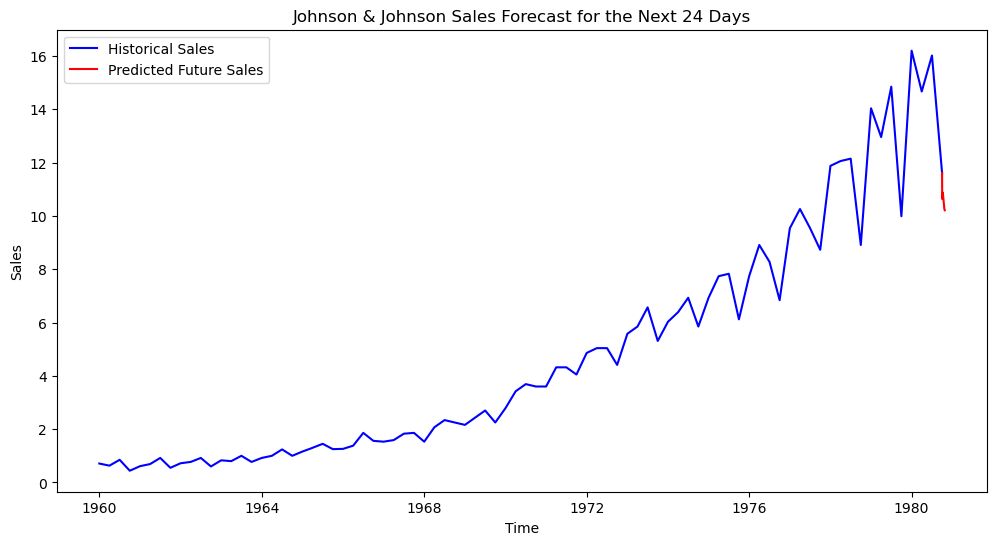

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['data'], color='blue', label='Historical Sales')

# To join the lines, start the predicted_dates at the last date of historical data
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')

# Ensure the first prediction follows the last historical data point
# by appending the last historical point to the beginning of the predicted series
combined_future_dates = np.insert(predicted_dates, 0, data.index[-1])
combined_future_sales = np.insert(future_days, 0, data['data'].iloc[-1])

plt.plot(combined_future_dates, combined_future_sales, color='red', label='Predicted Future Sales')
plt.title(f'Johnson & Johnson Sales Forecast for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Arima Model for Amazon Share Price

In [ ]:
# Reading in the data and setting the date to be the index value
df = pd.read_csv('AMZN.csv', index_col='Date', parse_dates=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-13,97.849998,99.680000,96.910004,99.540001,99.540001,52841500
2023-02-14,98.410004,100.919998,97.519997,99.699997,99.699997,56202900
2023-02-15,99.089996,101.169998,98.449997,101.160004,101.160004,48053900
2023-02-16,99.209999,100.629997,98.099998,98.150002,98.150002,56339200
2023-02-17,97.800003,97.940002,95.650002,97.199997,97.199997,59967700


In [ ]:
# Fectching the Closing Price
df=df[['Close']]

Text(0.5, 1.0, 'Amazon Shares Figure')

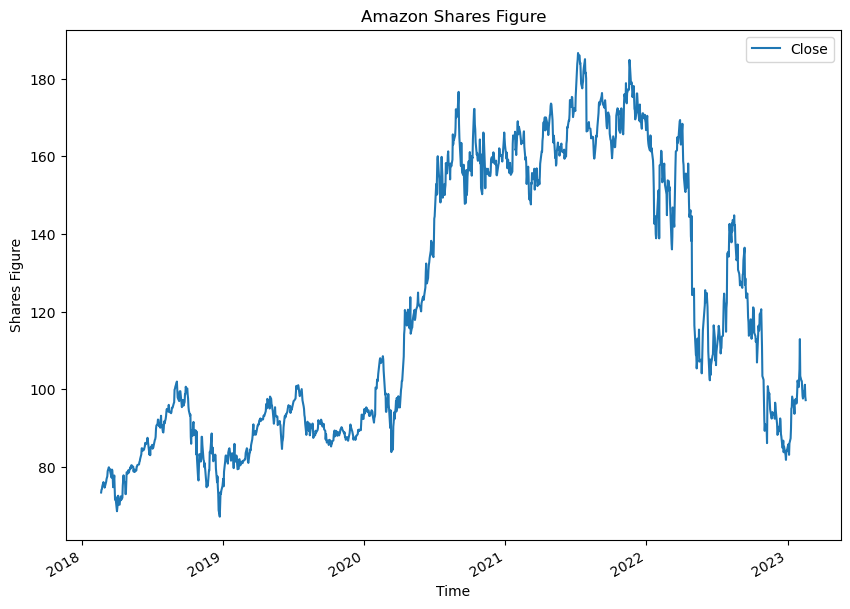

In [ ]:
#checking the plot
df.plot()
plt.xlabel('Time')  # Labeling the x-axis as Time
plt.ylabel('Shares Figure')  # Labeling the y-axis as Sales Figure
plt.title('Amazon Shares Figure')

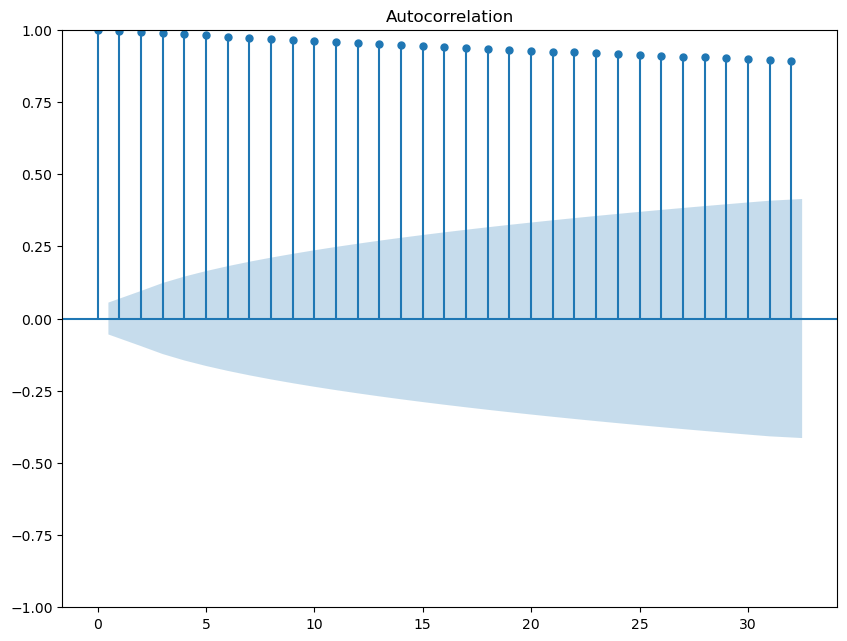

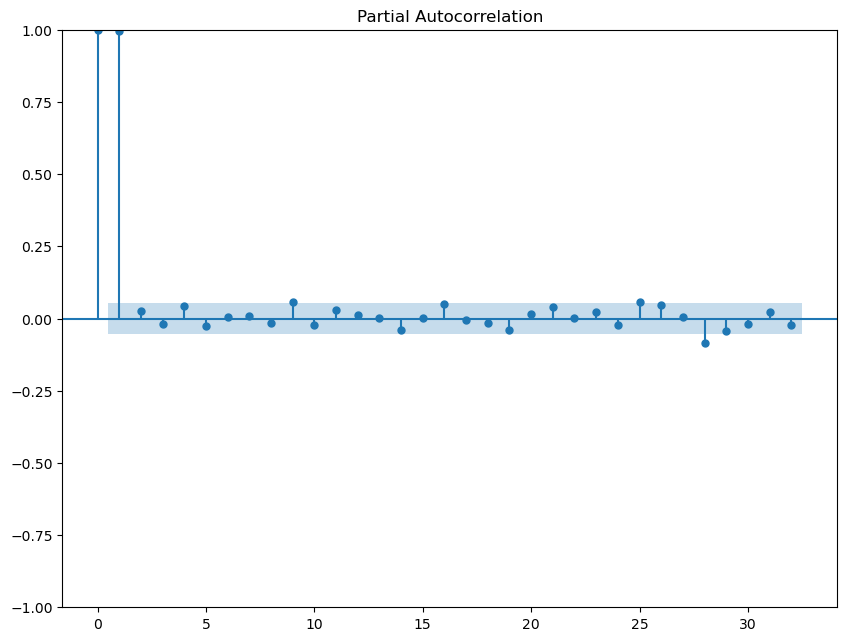

In [ ]:
# Checking the ACF and PACF
df_plot=plot_acf(df['Close'])
df_plot=plot_pacf(df['Close'])

In [ ]:
# Checking if the model is stationary using Adfuller test
adf_test=adfuller(df['Close'])
print(f'p-value: {adf_test[1]}') # the p value is > that 0.05 meaning the data is not stationary


p-value: 0.4529710546516677


In [ ]:
# Making the data stationary by taking the log and differencing

# taking the log to stabilize the variance
df_log = np.log(df['Close'])
df_log

Date
2018-02-20    4.296162
2018-02-21    4.306036
2018-02-22    4.307667
2018-02-23    4.317488
2018-02-26    4.332015
                ...   
2023-02-13    4.600560
2023-02-14    4.602166
2023-02-15    4.616703
2023-02-16    4.586497
2023-02-17    4.576771
Name: Close, Length: 1259, dtype: float64

In [ ]:
# using differencing to remove trend
df_log_diff =df_log.diff().dropna()
df_log_diff.head()

Date
2018-02-21    0.009874
2018-02-22    0.001631
2018-02-23    0.009821
2018-02-26    0.014527
2018-02-27   -0.006572
Name: Close, dtype: float64

Text(0.5, 1.0, 'Amazon Shares Figure')

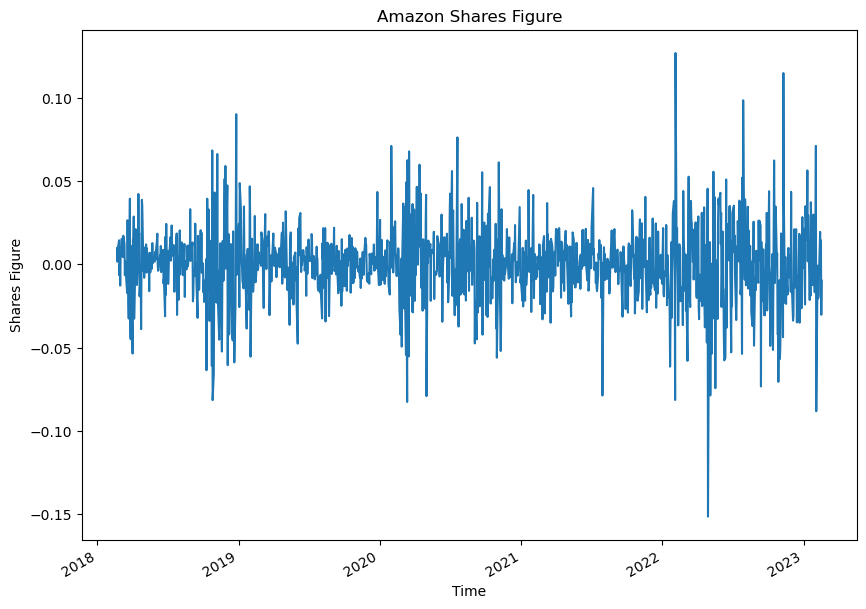

In [ ]:
# Checking the plot after taking log and differencing
df_log_diff.plot()
plt.xlabel('Time')  # Labeling the x-axis as Time
plt.ylabel('Shares Figure')  # Labeling the y-axis as Sales Figure
plt.title('Amazon Shares Figure')

In [ ]:
# Confirming the stationarity with the adfuller test
ad=adfuller(df_log_diff)
print(f'p-value: {ad[1]}')

p-value: 0.0


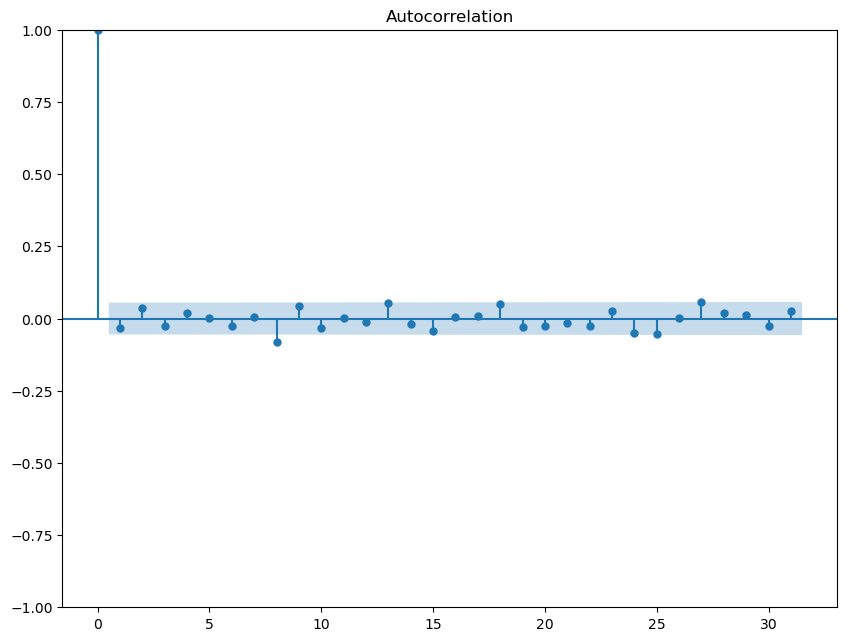

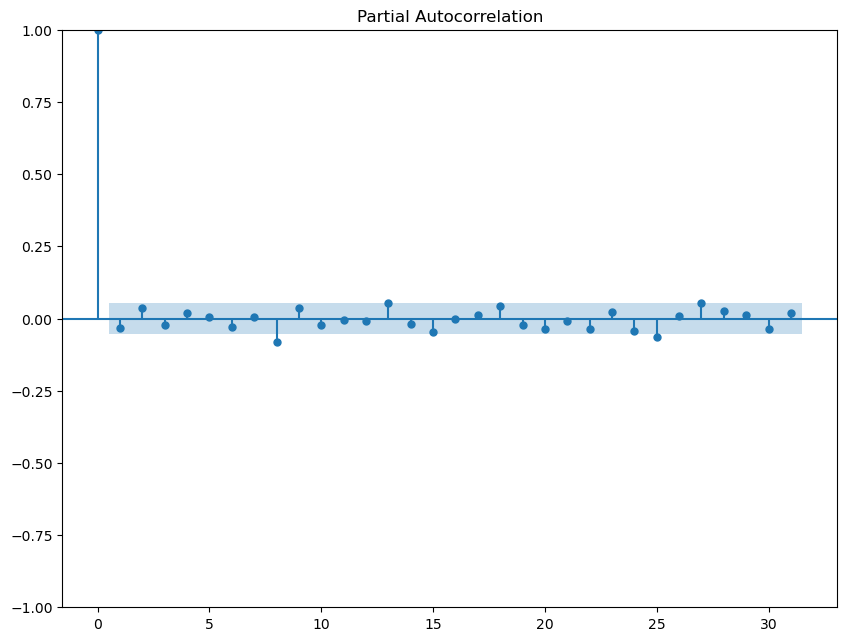

In [ ]:
# Checking the ACF and PACF after making the data stationary
acf_df_plot=plot_acf(df_log_diff)
pacf_df_plot=plot_pacf(df_log_diff)

In [ ]:
# Finding the best ARMA(p,q) model fit using the pmdarima automated best model fit finder
auto = pm.auto_arima(df['Close'], trace=True)
auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6124.257, Time=3.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6132.580, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6133.913, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6133.946, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6130.639, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6134.711, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6134.812, Time=0.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6125.980, Time=2.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6126.022, Time=2.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6133.629, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6135.059, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6135.406, Time=0.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6127.281, Time=4.54 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6122.315, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3056.158
Date:                Mon, 11 Mar 2024   AIC                           6122.315
Time:                        20:35:23   BIC                           6148.002
Sample:                             0   HQIC                          6131.969
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6946      0.015   -111.815      0.000      -1.724      -1.665
ar.L2         -0.9604      0.015    -64.729      0.000      -0.989      -0.931
ma.L1          1.6972      0.011    152.240      0.000       1.675       1.719
ma.L2          0.9786      0.011     90.456      0.000       0.957       1.000
sigma2         7.5418      0.165     45.656      0.000       7.218       7.866
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1737.60
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Splitting the data into train and test

len(df)
train_df=df[:1250]
test_df=df[1250:]

In [ ]:
# training the model on the training data
model_amz=ARIMA(train_df['Close'],
                        order=(2,1,2),
                        seasonal_order=(0,0,0,0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
model_amz=model_amz.fit()
model_amz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1250
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3033.877
Date:                Mon, 11 Mar 2024   AIC                           6077.754
Time:                        20:35:25   BIC                           6103.392
Sample:                             0   HQIC                          6087.393
                               - 1250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6819      0.022    -77.383      0.000      -1.724      -1.639
ar.L2         -0.9447      0.021    -44.775      0.000      -0.986      -0.903
ma.L1          1.6839      0.018     95.957      0.000       1.650       1.718
ma.L2          0.9652      0.017     56.927      0.000       0.932       0.998
sigma2         7.5969      0.171     44.314      0.000       7.261       7.933
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1711.70
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Predicting with the trained Model
start=len(train_df)
end=len(train_df)+len(test_df)-1
pred_amz=model_amz.predict(start=start, end=end, type='levels')
pred_amz.index=df.index[start:end+1]
print(pred_amz)

Date
2023-02-07    101.902266
2023-02-08    102.121111
2023-02-09    102.015415
2023-02-10    101.986439
2023-02-13    102.135026
2023-02-14    101.912493
2023-02-15    102.146398
2023-02-16    101.963224
2023-02-17    102.050331
Name: predicted_mean, dtype: float64


In [ ]:
# finding the mean of the test data
test_df.mean()

Close    99.306667
dtype: float64

In [ ]:
# Finding the root mean square
from math import sqrt
rmse=sqrt(mean_squared_error(pred_amz, test_df['Close']))
print(rmse)

print(mean_absolute_error(pred_amz, test_df['Close']))

3.1341892595531298
2.765351906094589


## Forecasting for the next 24 period

In [ ]:
# building on the full dataset
final_model_amz=ARIMA(df['Close'],
                        order=(2,1,2),
                        seasonal_order=(0,0,0,0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
final_model_amz=final_model_amz.fit()
final_model_amz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3052.704
Date:                Mon, 11 Mar 2024   AIC                           6115.407
Time:                        20:35:26   BIC                           6141.082
Sample:                             0   HQIC                          6125.057
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6816      0.022    -77.474      0.000      -1.724      -1.639
ar.L2         -0.9442      0.021    -44.802      0.000      -0.986      -0.903
ma.L1          1.6836      0.018     95.965      0.000       1.649       1.718
ma.L2          0.9648      0.017     56.905      0.000       0.932       0.998
sigma2         7.5602      0.170     44.544      0.000       7.228       7.893
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1736.62
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Specifying the range of forecast
start = len(df)-1
end = start + 24 - 1

# Perform the forecast
pred_result_f = final_model_amz.get_prediction(start=start, end=end, dynamic=False, typ='levels')

# Accessing the predicted mean
pred_final_f = pred_result_f.predicted_mean.rename(' 24 period Forecast')

# Generate the index for future dates and assign it to the forecast
index_future_dates = pd.date_range(start='2023-02-17', periods=24, freq='D')
pred_final_f.index = index_future_dates

In [ ]:
# getting the final result
predictions_int = final_model_amz.get_forecast(steps=24)

# Accessing the predicted mean
predicted_mean = predictions_int.predicted_mean

# To get the confidence intervals for the forecast
conf_int = predictions_int.conf_int()

# If you want to display both the predicted mean and the confidence intervals
#print("Predicted Mean:\n", predicted_mean)
#print("\nConfidence Intervals:\n", conf_int)

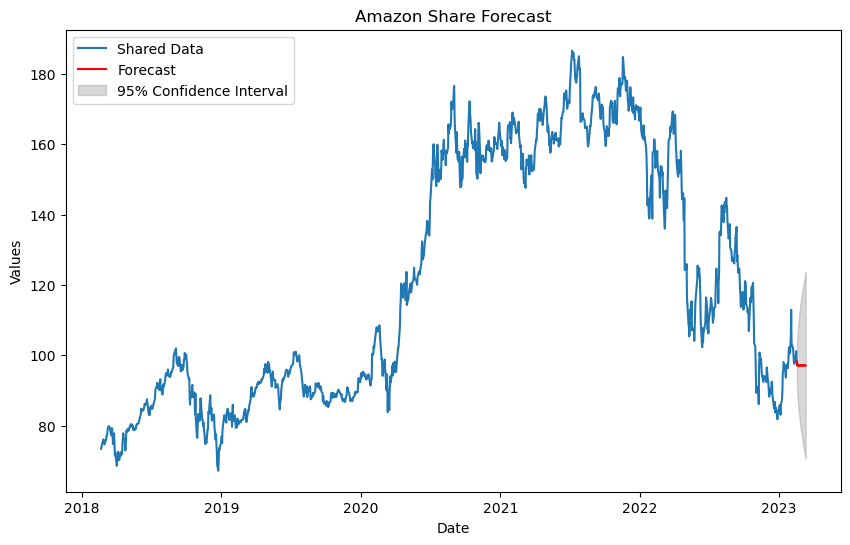

In [ ]:
# Plotting the data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Shared Data')  #
plt.plot(pred_final_f.index, pred_final_f, label='Forecast', color='red')
plt.fill_between(pred_final_f.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title('Amazon Share Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# LSTM Model for Amazon Shares

## Preprocessing the Data and Splitting the Data

In [ ]:
# Selecting only the closing price as that is what will be used for building our model and prediction
df2 = df[['Close']]

# Prepocessing the data so it can be suitable for Deep learning
scaler = MinMaxScaler()
scaled_df =scaler.fit_transform(df2['Close'].values.reshape(-1,1))

# splitting the data into training and testing
train_size = int(len(scaled_df) * 0.90) # size of training data is 80% of the total data
test_size = len(scaled_df) - train_size # size of testing data which will be 25%


train_df,test_df = scaled_df[0:train_size,:],scaled_df[train_size:len(scaled_df),:]
train_df.shape, test_df.shape


((1133, 1), (126, 1))

In [ ]:
# number of previous time steps(sequence of time) to use before making prediction on the next one
steps=30

#creating a sequence of data that uses 30 past data(X) to make prediction(y)
train_generator_df= TimeseriesGenerator(train_df,train_df, length=steps, batch_size=20)
test_generator_df= TimeseriesGenerator(test_df, test_df, length=steps, batch_size=20)

In [ ]:
# Building a Sequential LSTM Model
model_df = Sequential()
model_df.add(LSTM(units=30, return_sequences=True, input_shape=(30,1)))
model_df.add(LSTM(units=30, return_sequences=True))
model_df.add(LSTM(units=30, return_sequences=True))
model_df.add(LSTM(units=30))
model_df.add(Dense(1))

# compiling the model
model_df.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the model on the training data and assessing  its performance on the validation data
model_df.fit(train_generator_df, epochs=100, batch_size=20)

Epoch 1/100
56/56 [==============================] - 14s 44ms/step - loss: 0.0390 - mean_absolute_error: 0.1222
Epoch 2/100
56/56 [==============================] - 2s 43ms/step - loss: 0.0159 - mean_absolute_error: 0.0916
Epoch 3/100
56/56 [==============================] - 2s 43ms/step - loss: 0.0064 - mean_absolute_error: 0.0565
Epoch 4/100
56/56 [==============================] - 2s 42ms/step - loss: 0.0074 - mean_absolute_error: 0.0609
Epoch 5/100
56/56 [==============================] - 3s 47ms/step - loss: 0.0061 - mean_absolute_error: 0.0575
Epoch 6/100
56/56 [==============================] - 3s 53ms/step - loss: 0.0079 - mean_absolute_error: 0.0651
Epoch 7/100
56/56 [==============================] - 3s 48ms/step - loss: 0.0056 - mean_absolute_error: 0.0538
Epoch 8/100
56/56 [==============================] - 3s 47ms/step - loss: 0.0055 - mean_absolute_error: 0.0535
Epoch 9/100
56/56 [==============================] - 3s 44ms/step - loss: 0.0061 - mean_absolute_error: 0.0577


In [ ]:
# Predicting on the test data
lstm_predictions_df = model_df.predict(test_generator_df)

5/5 [==============================] - 2s 18ms/step


# MODEL EVALUATION

In [ ]:
# Inverting the predictions
prediction_amz= scaler.inverse_transform(lstm_predictions_df)
actual_shares = scaler.inverse_transform(test_df[steps:])

In [ ]:
# Evaluating the model using Root Mean Square Error
mse=mean_squared_error(actual_shares,prediction_amz)
rmse_df=mse**(1/2)

# Evaluating the model using Root Mean Square Error
r2=mean_absolute_error(actual_shares,prediction_amz)

print(f'the Root Mean Square Error is {rmse_df}')
print(r2)

the Root Mean Square Error is 3.3758199526521464
2.600260055603027


# **FORECASTING AMAZON SHARE WITH OUR LSTM  MODEL**

In [ ]:
# Creating a Def Function to predict the next 24 days

def predict_future_days(model_df, base_data, days_to_predict, scaler, look_back):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model_df.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions


In [ ]:
# Predict next 24 days
look_back = 30
days_to_predict = 24
future_days = predict_future_days(model_df, scaled_df, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 46ms/step


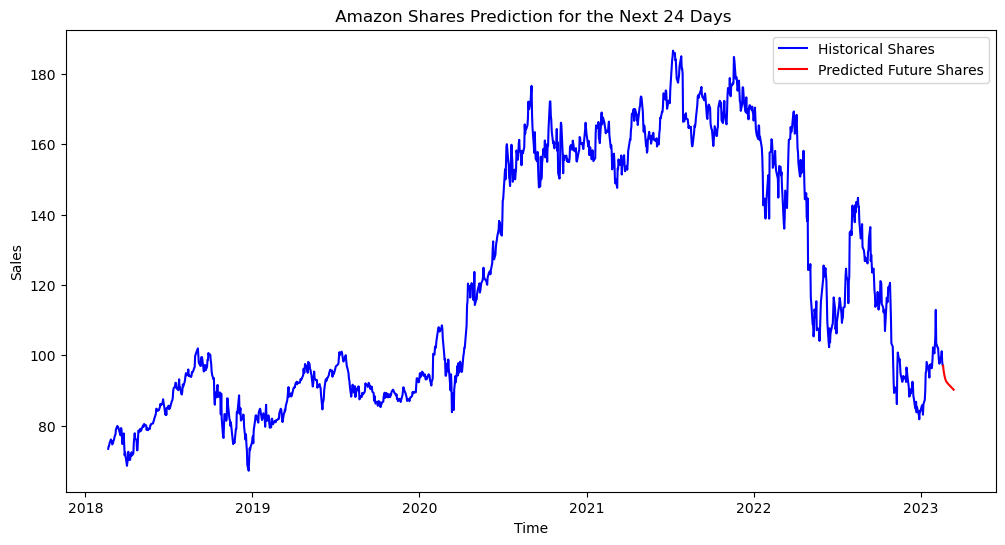

In [ ]:
# Plot the predictions
predicted_dates = pd.date_range(start=df.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], color='blue', label='Historical Shares')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Shares')
plt.title(f' Amazon Shares Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()